In this notebook, I induce Rabi oscillation *with* pre-determined DRAG correction

### References

[1]: Li, Z., Liu, P., Zhao, P. *et al.* Error per single-qubit gate below 10−4 in a superconducting qubit. *npj Quantum Inf* **9**, 111 (2023). [https://doi.org/10.1038/s41534-023-00781-x](https://doi.org/10.1038/s41534-023-00781-x).

[2]: Z. Chen *et al.* Measuring and Suppressing Quantum State Leakage in a Superconducting Qubit. *Phys. Rev. Lett.* **116**, 020501 (2016) [https://doi.org/10.1103/PhysRevLett.116.020501](https://doi.org/10.1103/PhysRevLett.116.020501). 

## Dependencies

In [7]:
%config InlineBackend.figure_formats = ['svg']

import os
os.chdir('/Users/ngdnhtien/Codespace/PulsatingPulseShop/')

# Necessary dependencies

# qiskit
from qiskit import pulse
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
from qiskit_ibm_provider import IBMProvider

# qutritium
from utility import *
from constant import *

# numerical
import numpy as np
from scipy.optimize import curve_fit
import pickle 

# plot
from matplotlib.ticker import MultipleLocator

plt.rcParams['axes.linewidth'] = 1.25

In [8]:
provider = IBMProvider()
print(provider.backends())

backend = provider.get_backend('ibm_brisbane')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
dt = backend_config.dt

qubit = 109
cbit = 0
num_qubits = int(qubit+1)
num_cbits = 1
weight = 1

[<IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>]


In [11]:
qubit_01_freq = backend_defaults.qubit_freq_est[qubit]
qubit_anharmonicty = backend_properties.qubits[qubit][3].value*GHz
qubit_12_freq = qubit_01_freq + qubit_anharmonicty

p12_amp = 0.22289722723304814

In [12]:
with pulse.build(backend=backend) as hp12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=96, amp=p12_amp/2, sigma=24, beta=-0.4, name='hp12'), drive_chan)
    
hp12_gate = Gate(r'X_{\pi/2}^{(12)}', weight, [])
    
with pulse.build(backend=backend) as p12_sched:
    drive_chan = qiskit.pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Drag(duration=96, amp=p12_amp, sigma=24, beta=-0.4, name='p12'), drive_chan)

p12_gate = Gate(r'X_{\pi}^{(12)}', weight, [])

In [10]:
with pulse.build(backend=backend) as delay_10us:
    drive_chan = pulse.drive_channel(qubit)
    pulse.delay(20000, drive_chan)
    
with pulse.build(backend=backend) as delay_20us:
    drive_chan = pulse.drive_channel(qubit)
    pulse.delay(40000, drive_chan)
    
delay_gate = Gate('Delay', weight, [])

In [14]:
ground_circ = QuantumCircuit(num_qubits, num_cbits)
ground_circ.append(delay_gate, [qubit])
ground_circ.measure(qubit, cbit)
ground_circ.add_calibration(delay_gate, [qubit], delay_20us)

first_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
first_excited_state_circ.x(qubit)
first_excited_state_circ.measure(qubit, cbit)

second_excited_state_circ = QuantumCircuit(num_qubits, num_cbits)
second_excited_state_circ.x(qubit)
second_excited_state_circ.append(p12_gate, [qubit])
second_excited_state_circ.measure(qubit, cbit)
second_excited_state_circ.add_calibration(p12_gate, [qubit], p12_sched)

discrim_circs = qiskit.transpile([ground_circ, first_excited_state_circ, second_excited_state_circ], backend=backend)

## Rabi circuits

In [15]:
amps = np.linspace(-1, 1, 100)

rabi_circs = []

rabi12_gate = Gate(r'Rabi Gate', weight, [])

for amp in amps:
    
    with pulse.build(backend=backend) as rabi12_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(rough_qubit_12_freq, drive_chan)
        pulse.play(pulse.Drag(duration=96, amp=amp, sigma=24, beta=-0.4), drive_chan)

    rabi12_circ = QuantumCircuit(num_qubits, num_cbits)
    rabi12_circ.x(qubit) # prepare |1>
    rabi12_circ.append(rabi12_gate, [qubit])
    rabi12_circ.measure(qubit, cbit)
    rabi12_circ.add_calibration(rabi12_gate, [qubit], rabi12_sched)
                   
    rabi_circs.append(rabi12_circ)

In [18]:
package = []

package = discrim_circs + rabi_circs

len(package)

103

In [19]:
rough_rabi_exp = backend.run(package, meas_level=1, meas_return='single', shots=8192)

In [24]:
print(rough_rabi_exp.job_id(), rough_rabi_exp.status())

cp36kp6mbjng0083qva0 JobStatus.DONE


In [25]:
rough_rabi_exp = provider.backend.retrieve_job('cp36kp6mbjng0083qva0')

In [26]:
rough_rabi_data = DataAnalysis(experiment=rough_rabi_exp, average=False, shots=8192, qubit=0)
rough_rabi_data.retrieve_data(average=False)
rough_rabi_data.build_discrim()
rough_rabi_data.count_pop()
rough_rabi_data.error_mitiq()

In [33]:
rrwD_pop2 = rough_rabi_data.mitiq_data[3:, 2]
rrwD_pop1 = rough_rabi_data.mitiq_data[3:, 1]

len(rrwD_pop2)

100

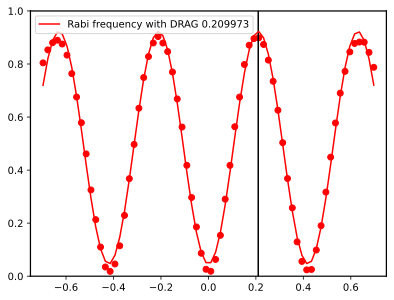

In [73]:
ex_p = 15

plt.scatter(amps[ex_p:-ex_p], rrwD_pop2[ex_p:-ex_p], color='red')
# plt.scatter(amps[ex_p:-ex_p], rrwD_pop1[ex_p:-ex_p], color='blue')

rrwD_params, rrwD_fit = fit_function(amps[ex_p:-ex_p], rrwD_pop2[ex_p:-ex_p], 
                                     lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                                    [1.0, 0, 0.4, 0])

plt.ylim([0, 1])
plt.xlim([-0.75, 0.75])
plt.axvline(np.round(rrwD_params[2]/2,6), color='black')
plt.plot(amps[ex_p:-ex_p], rrwD_fit, color='red', label=f'Rabi frequency with DRAG {np.round(rrwD_params[2]/2,6)}')
plt.legend()

In [75]:
rrwD_params[2]/2

0.2099727888949895

In [74]:
import pickle

with open('./calibrator/rabi/data/23dec/rabi96_wD.pkl', 'wb') as f:
    pickle.dump(rrwD_pop2[ex_p:-ex_p], f)